<a href="https://colab.research.google.com/github/shuyunDENG/Projet-final/blob/main/deepromoter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Week 3: Introduction
Welcome to this laboratory class focused on **DeePromoter** and the crucial role of **promoter regions** in gene regulation. Promoter regions are essential DNA sequences that control the initiation of transcription, influencing gene expression.

The central prediction of this study is that **DeePromoter**, a robust deep learning model, can identify and classify short eukaryotic promoter sequences in both humans and mice. This model is designed to predict **TATA-type** promoters (those with the TATA box) as well as **non-TATA-type** promoters.

In this session, we will focus on **DeePromoter** and investigate how it performs when trained on different datasets. We will explore its limitations and the interpretations of its results, providing a detailed understanding of its capabilities. By the end of this session, you will gain insights into how DeePromoter handles promoter prediction and the factors that influence its performance across various datasets.

Sources
1. [Publication](https://www.frontiersin.org/journals/genetics/articles/10.3389/fgene.2019.00286/full)
2. [Implementation repository](https://github.com/egochao/DeePromoter/tree/main)

### 2. DeePromoter
The main idea behind the DeePromoter algorithm is to leverage advanced deep learning techniques to accurately predict eukaryotic promoter sequences from raw DNA sequences, specifically targeting both TATA and non-TATA promoters in human and mouse genomes. Here’s an overview of the core components and methodology:

**1. Architecture**

DeePromoter combines two distinct neural network architectures:

- Convolutional Neural Network (CNN): This layer is responsible for automatically extracting features from the input sequences. The CNN consists of multiple convolutional layers that apply filters to the sequence data, capturing local patterns and motifs related to promoter sequences.

- Bidirectional Long Short-Term Memory (BiLSTM): Following the CNN layers, BiLSTM is used to capture long-range dependencies between the nucleotide sequences. BiLSTM processes the sequence data in both forward and backward directions, enhancing the model's ability to understand contextual information.

**2. Challenging Negative Set**

Instead of using random (non-promoter) genomic  sequences as the negative dataset, DeePromoter adopts a more sophisticated approach by constructing a challenging negative set from the promoter sequences. This was done to improve the model's discrimination ability and reduce false positive predictions. The challenging aspect of the negative set pushes the algorithm to learn a deeper representation of the features that distinguish promoters from non-promoters.
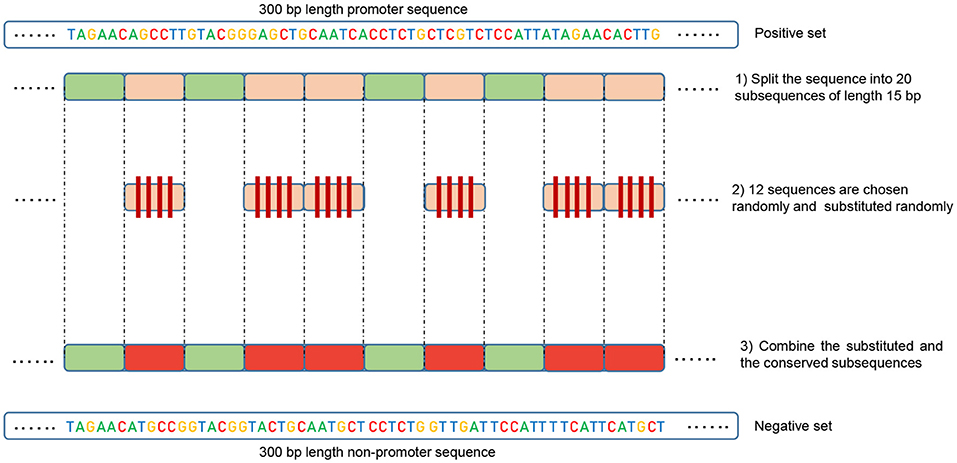

**3. Computation and Training**

- The model processes sequences of a fixed length (300 bp), focusing on the region around transcription start sites.

- The architecture includes multiple convolutional layers with varying window sizes, allowing it to capture different types of sequence features.

- Dropout layers are utilized to prevent overfitting and improve generalization.

**4. Evaluation and Results**

The DeePromoter model is trained on a curated dataset that includes both TATA and non-TATA promoters. The evaluation phase compares its performance against existing tools such as CNNProm, demonstrating superior results in terms of precision, recall, and Matthews correlation coefficient (MCC) metrics across the different datasets.

**5. Impact**

The algorithm's ability to accurately differentiate between promoter and non-promoter sequences offers significant improvements in the field of bioinformatics, particularly in the study of gene regulation. By effectively reducing false positives while maintaining high sensitivity, DeePromoter positions itself as a valuable tool for researchers in genomics and related fields.

In summary, the main idea behind DeePromoter is to utilize a combination of CNN and LSTM architecture, improved dataset preparation, and deep learning techniques to enhance the accuracy and reliability of promoter sequence prediction.

### 3. Let's test it

##### 3.1 Clone the repo to your working directory
Remember: The working directory in colab automatically deletes after working. If you want to save your results- add repo to your google drive.

In [ ]:
!git clone https://github.com/egochao/DeePromoter.git

Cloning into 'DeePromoter'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 60 (delta 20), reused 47 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (60/60), 4.83 MiB | 7.81 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [ ]:
%cd DeePromoter

/content/DeePromoter


##### 3.2 Install dependencies

In [ ]:
#!pip install -r requirements.txt
!pip install icecream

##### 3.3 Training and/or loading DeePromoter model

In [ ]:
import torch
import math
import argparse
import torch.optim as optim
from torch import nn
from icecream import ic
from pathlib import Path

from modules.deepromoter import DeePromoter
from dataloader import load_data_test, load_data
from DeePromoter.test import evaluate, mcc
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(data_path, pretrain=None, exp_name="test", training=True, ker=None, epoch_num=1000):
    """
    Training
    :param data_path: Path to the txt data file
    :param pretrain: Path to weight for continue training
    :param exp_name: Folder name to save the results
    :param training: If False, performs testing only
    :param ker: List kernel size of list CNN applying to the protein sequence
    :param epoch_num: Max epoch to train
    """
    if ker is None:
        ker = [27, 14, 7]

    # create the experiment folder to save the result
    output = Path("./output")
    output.mkdir(exist_ok=True)
    exp_folder = output.joinpath(exp_name)
    exp_folder.mkdir(exist_ok=True)

    # load data
    ic("Data loading")
    data = load_data(data_path, device=device)
    train_pos, val_pos, test_pos, train_neg, val_neg, test_neg = data

    # model define
    net = DeePromoter(ker)
    net.to(device)

    # load pre-train model
    if pretrain is not None:
        net.load_state_dict(torch.load(pretrain))

    # define loss, optimizer
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=0.00001)
    mcc_scores, precision_scores, recall_scores = [], [], []
    running_loss = 0
    best_mcc = 0
    best_precision = 0
    best_recall = 0
    break_after = 10
    last_update_best = 0
    pbar = range(epoch_num)
    ic("Start training")
    if training:
        for epoch in pbar:
            for i, (batch_pos, batch_neg) in enumerate(zip(train_pos, train_neg)):
                inputs = torch.cat((batch_pos[0], batch_neg[0]), dim=0)
                labels = torch.cat((batch_pos[1], batch_neg[1]), dim=0)

                # zero the parameter gradients
                optimizer.zero_grad()

                # pass model to
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()

                running_loss += loss.item()


            if epoch % 10 == 0:
                torch.save(net.state_dict(), str(exp_folder.joinpath("epoch_" + str(epoch) + ".pth")))
                net.eval()
                eval_data, _ = evaluate(net, [val_pos, val_neg])
                precision, recall, MCC = mcc(eval_data)
                mcc_scores.append(MCC)
                precision_scores.append(precision)
                recall_scores.append(recall)
                net.train()
                ic("Epoch :", epoch, "Experiment :", exp_name)
                ic("precision :", precision)
                ic("recall :", recall)
                ic("MCC :", MCC)

                # save best model
                if precision > best_precision:
                    best_precision = precision
                    ic("Update best precision")
                    torch.save(net.state_dict(), str(exp_folder.joinpath("best_precision.pth")))
                if recall > best_recall:
                    best_recall = recall
                    ic("Update best recall")
                    torch.save(net.state_dict(), str(exp_folder.joinpath("best_recall.pth")))
                if MCC > best_mcc:
                    ic("Update best MCC")
                    best_mcc = MCC
                    torch.save(net.state_dict(), str(exp_folder.joinpath("best_mcc.pth")))
                    last_update_best = 0
                else:
                    last_update_best += 1
                if last_update_best >= break_after:
                    break
            if last_update_best >= break_after:
                break

    return mcc_scores, precision_scores, recall_scores



In [ ]:
#you can train the model yourself (uncomment the section to do so) but it takes approx 1hour on gpu
data_path_human_noTATA = "./data/human/nonTATA/hs_pos_nonTATA.txt"
mcc_scores_no, precision_scores_no, recall_scores_no = train(data_path_human_noTATA, pretrain=None, exp_name="train_human_noTATA", training=True, ker=None, epoch_num=400)


ic| 'Data loading'


Key error :  N 200
Key error :  N 200


ic| 'Start training'
ic| "Epoch :": 'Epoch :'
    epoch: 0
    "Experiment :": 'Experiment :'
    exp_name: 'train_human_noTATA'
ic| 'precision :', precision: 0.7374429223744292
ic| 'recall :', recall: 0.6233114627556928
ic| 'MCC :', MCC: 0.40628471819514456
ic| 'Update best precision'
ic| 'Update best recall'
ic| 'Update best MCC'
ic| "Epoch :": 'Epoch :'
    epoch: 10
    "Experiment :": 'Experiment :'
    exp_name: 'train_human_noTATA'
ic| 'precision :', precision: 0.8882947118241236
ic| 'recall :', recall: 0.5769972983404091
ic| 'MCC :', MCC: 0.5385940587090312
ic| 'Update best precision'
ic| 'Update best MCC'
ic| "Epoch :": 'Epoch :'
    epoch: 20
    "Experiment :": 'Experiment :'
    exp_name: 'train_human_noTATA'
ic| 'precision :', precision: 0.8963075366717248
ic| 'recall :', recall: 0.6839058278656889
ic| 'MCC :', MCC: 0.6225176149677563
ic| 'Update best precision'
ic| 'Update best recall'
ic| 'Update best MCC'
ic| "Epoch :": 'Epoch :'
    epoch: 30
    "Experiment :": 'Exper

##### 3.4 Check the performance

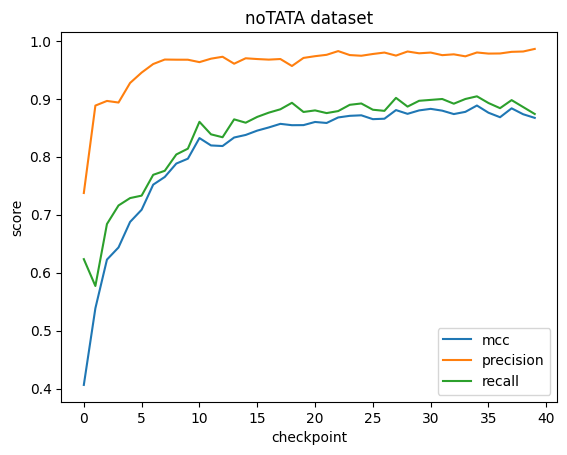

In [ ]:
plt.plot(mcc_scores_no, label='mcc')
plt.plot(precision_scores_no, label='precision')
plt.plot(recall_scores_no, label='recall')
plt.title('noTATA dataset')
plt.legend()
plt.xlabel('checkpoint')
plt.ylabel('score')
plt.show()

The plot above shows the metrics reflecting the model's learning progress. Now, let's examine how it classifies test examples.

In [ ]:
#we will load already trained model here
path_noTATA_pretrained_model = './data/models/model_noTATA.pth'

In [ ]:
import torch
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, ax=None):
    """
    Plot the confusion matrix using matplotlib without labels and seaborn.
    :param cm: confusion matrix
    :param ax: axis to plot on, if None a new plot will be created
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the confusion matrix
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)

    # Annotate the confusion matrix cells with the counts
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, str(val), ha='center', va='center', color='black', fontsize=14)

    ax.set_xlabel('Predicted Labels', fontsize=14)
    ax.set_ylabel('True Labels', fontsize=14)
    ax.set_title('Confusion Matrix', fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

def evaluate(net, loaders):
    """
    Infer and check results against labels
    :param net: Model object in eval state
    :param loaders: List of torch dataloader for infer
    :return: List of [correct, total] for every dataloader, list of predicted results in int type, list of confusion matrices
    """
    eval_result = list()
    ltotal = list()
    lcorrect = list()
    pred_result = list()
    true_result = list()  # To store the true labels for further analysis

    for load in loaders:
        total = 0
        correct = 0
        pred_list = list()
        true_list = list()  # To store true labels for confusion matrix

        for data in load:
            inputs = data[0]
            labels = data[1]
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pred_list += list(predicted.cpu().numpy())
            true_list += list(labels.cpu().numpy())


        acc = correct / total
        eval_result.append(acc)
        lcorrect.append(correct)
        ltotal.append(total)
        pred_result.append(pred_list)
        true_result.append(true_list)

        # Compute confusion matrix for this dataloader
        cm = confusion_matrix(true_list, pred_list)


    return (lcorrect, ltotal), pred_result, cm


First, we'll use the function suggested by the authors of the repository. For testing the model, they input only promoters (without modifications, i.e., the negative dataset) and then check how many of these were classified as positive examples of promoters.

In [ ]:
def test(data_path, pretrain,device,ker=None):
    if ker is None:
        ker = [27, 14, 7]

    dataloader = load_data_test(data_path=data_path, batch_size=32, device=device, num_cpu=10)

    # model define
    net = DeePromoter(ker)
    net.to(device)

    net.load_state_dict(torch.load(pretrain,map_location=torch.device(device)))


    net.eval()
    eval_data, results, confusion_matrice = evaluate(net, [dataloader])

    return eval_data, results, confusion_matrice

In [ ]:
eval_data, results, confusion_matrice = test('/content/DeePromoter/data/human/nonTATA/hs_pos_nonTATA.txt', pretrain=path_noTATA_pretrained_model, device=device, ker=None)

Key error :  N 200


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/conv.py:370: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  return F.conv1d(
<ipython-input-9-bbacde621b56>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute ar

In [ ]:
positives = 0
all = 0
for example in results[0]:
  positives += example
  all += 1
print(f'Out of {all} promoters model predicted {positives} postitive promoters which is {round((positives/all),2)*100}%')

Out of 25920 promoters model predicted 24343 postitive promoters which is 94.0%


Now, let's modify the function provided by the authors to evaluate the model's performance in a more standard machine learning approach, using a test dataset with positive and negative examples separated during the data preparation process.

In [ ]:
from torch.utils.data import DataLoader, ConcatDataset

def test_new(data_path, pretrain, ker=None):
    if ker is None:
        ker = [27, 14, 7]

    dataloader = load_data(data_path, device=device)
    # Assuming `positive_dataloader` and `negative_dataloader` are already defined in the repository files
    positive_dataloader = dataloader[2]  # Your DataLoader for positive examples
    negative_dataloader = dataloader[5]  # Your DataLoader for negative examples

    # Extract datasets from each DataLoader
    positive_dataset = positive_dataloader.dataset
    negative_dataset = negative_dataloader.dataset

    # Combine the datasets
    combined_dataset = ConcatDataset([positive_dataset, negative_dataset])

    # Create a new DataLoader from the combined dataset
    combined_dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

    # model define
    net = DeePromoter(ker)
    net.to(device)

    net.load_state_dict(torch.load(pretrain,map_location=torch.device(device)))

    net.eval()
    eval_data, results, confusion_matrice = evaluate(net, [combined_dataloader])

    return eval_data, results, confusion_matrice




Key error :  N 200
Key error :  N 200


<ipython-input-12-1c0437e32f13>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(pretrain,map_location=torch.device(device)))


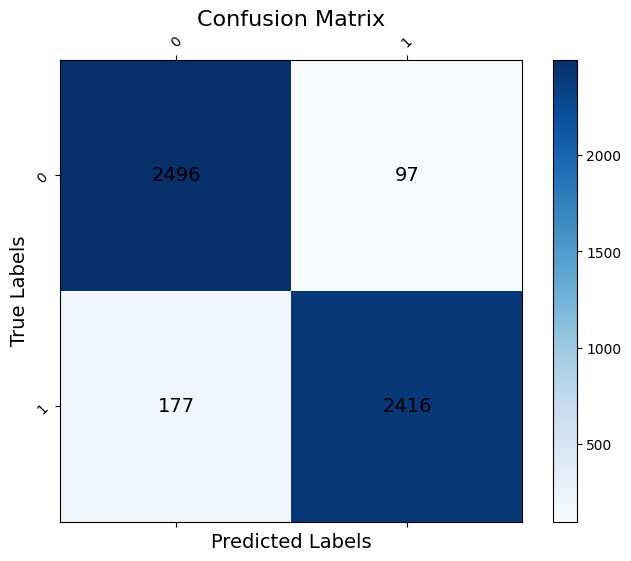

In [ ]:
eval_data_noTATA, results_noTATA , confusion_matrice_noTATA = test_new('/content/DeePromoter/data/human/nonTATA/hs_pos_nonTATA.txt',path_noTATA_pretrained_model )
plot_confusion_matrix(confusion_matrice_noTATA)

In [ ]:
accuracy_noTATA = eval_data_noTATA[0][0]/eval_data_noTATA[1][0]
print(f'The accuracy of the DeePromoter basedthe nonTATA dataset is {round(accuracy_noTATA,2)*100}%')

The accuracy of the DeePromoter basedthe nonTATA dataset is 95.0%


Great, we've demonstrated that DeePromoter performs well on the provided dataset, which consists solely of promoters with random modifications as the negative examples. But does this prove that it generalizes effectively? What will happen if we input completely random sequences from the human genome? Let's test it. We'll use a ready-made file for now, but if anyone is interested in how to obtain the file, they can check the script I’ve included (get_sequences.py). It uses Biopython to download the sequences from Ensembl.

##### 3.5 Testing the model on random sequences from human genome

In [ ]:
path_random_sequences = './data/sequences/random_sequences_25920.txt'

In [ ]:
eval_data_random_noTATA, results_random_noTATA, confusion_matrice_random_noTATA = test(path_random_sequences, pretrain=path_noTATA_pretrained_model,device=device ,ker=None)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-9-bbacde621b56>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary 

In [ ]:
positives = 0
all = 0
for example in results_random_noTATA[0]:
  positives += example
  all += 1
print(f'Out of {all} promoters model predicted {positives} postitive promoters which is {round((positives/all),2)*100}%')

Out of 4945 promoters model predicted 4434 postitive promoters which is 90.0%


Here, we have completely random genomic sequences, and the model predicted most of them as promoters, similar to what happened when we used the dataset consisting only of promoters. Now, let's see what happens when we cut the random sequences and mix some parts of them, as done in the negative dataset preparation for the original paper.

<ipython-input-12-1c0437e32f13>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(pretrain,map_location=torch.device(device)))


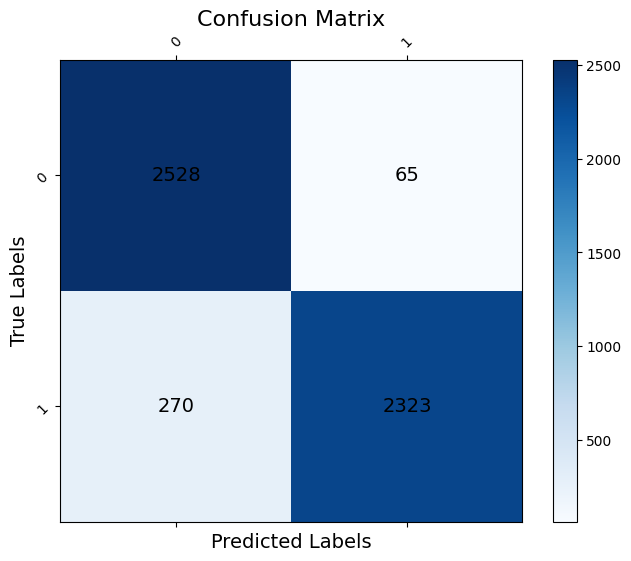

In [ ]:
eval_data_random_noTATA, results_random_noTATA, confusion_matrice_random_noTATA = test_new(path_random_sequences, pretrain=path_noTATA_pretrained_model, ker=None)
plot_confusion_matrix(confusion_matrice_random_noTATA)

In [ ]:
accuracy_noTATA_model = eval_data_random_noTATA[0][0]/eval_data_random_noTATA[1][0]
print(f'The accuracy of the DeePromoter for random sequences is {round(accuracy_noTATA_model,2)*100}%')

The accuracy of the DeePromoter for random sequences is 94.0%


**Question** What you can say about the result? Do you think this model is well suited to help find promoters regions?

##### 3.6 Conclusion
The model trained on a dataset consisting only of promoters and a negative set created from modified promoters performs well when focusing solely on machine learning metrics and results. However, this highlights the importance of understanding the data we’re working with. DeePromoter, trained only on promoters (with negative examples derived from positive ones), produces the same results for completely random sequences from human genome.

###4. Random sequences vs promoters

Now, let's adjust the original functions to utilize the model for distinguishing between real promoters and random sequences from the human genome. Files containing both promoters and random sequences are included in /data/sequences/ .

In [ ]:
path_promotors = './data/sequences/promoters.txt'
path_random_nopromotors = "./data/sequences/random_sequences_nopromoters.txt"

In [ ]:
from dataloader import LoadOnehot
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset

def load_data_new(data_path_promotors,data_path_random ,train_potion=0.8, batch_size=32, num_cpu=0, device="cuda"):
    """
    Load all data
    :param data_path: Path to txt file contain promoter (1 DNA promoter on 1 line)
    :param train_potion: The potion of dataset spend for training
    :param rand_neg: Add random of DNA to negative datset
    :param batch_size: Batch size for loader
    :param num_cpu: Number of CPU perform load data in prallel
    :param device: Device to load data on
    :return: List of train, val, test dataset for positive and negative datset
    """
    # get dataset
    manual_seed = torch.Generator().manual_seed(42)
    pos_data = LoadOnehot(data_path_promotors, device=device)

    #YOUR CODE HERE
    #Tip: examine LoadOnehot class in dataloader file
    #neq_data = YOUR CODE HERE


    # calculate the size of train and test dataset
    train_num = int(len(pos_data)*train_potion)
    val_num = int(len(pos_data)*(1-train_potion)*0.5)
    split_size = [train_num, val_num, len(pos_data) - train_num - val_num]

    # split dataset
    train_pos, val_pos, test_pos = random_split(pos_data, split_size, generator=manual_seed)
    train_neg, val_neg, test_neg = random_split(neg_data, split_size, generator=manual_seed)

    # data loader
    stack_dataset = [train_pos, val_pos, test_pos, train_neg, val_neg, test_neg]
    stack_loaders = list()
    for dataset in stack_dataset:
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_cpu)
        stack_loaders.append(data_loader)

    return stack_loaders


**Exercise** Check if your datasets have the same lenght to avoid the bias by over representation of one class.

**Exercise** Train the model that takes promoters as positive examples and random sequences as negative.

In [ ]:
def train_new(data_path_promotors,data_path_random, pretrain=None, exp_name="test", training=True, ker=None, epoch_num=1000):
    """
    Training
    :param data_path: Path to the txt data file
    :param pretrain: Path to weight for continue training
    :param exp_name: Folder name to save the results
    :param training: If False, performs testing only
    :param ker: List kernel size of list CNN applying to the protein sequence
    :param epoch_num: Max epoch to train
    """
    if ker is None:
        ker = [27, 14, 7]

    # create the experiment folder to save the result
    output = Path("./output")
    output.mkdir(exist_ok=True)
    exp_folder = output.joinpath(exp_name)
    exp_folder.mkdir(exist_ok=True)

    # load data
    ic("Data loading")
    data = load_data_new(data_path_promotors,data_path_random,device=device)
    train_pos, val_pos, test_pos, train_neg, val_neg, test_neg = data

    # model define
    net = DeePromoter(ker)
    net.to(device)

    # load pre-train model
    if pretrain is not None:
        net.load_state_dict(torch.load(pretrain))

    # define loss, optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.00001)
    mcc_scores, precision_scores, recall_scores = [], [], []
    running_loss = 0
    best_mcc = 0
    best_precision = 0
    best_recall = 0
    break_after = 10
    last_update_best = 0
    pbar = range(epoch_num)
    ic("Start training")
    if training:
        for epoch in pbar:
            for i, (batch_pos, batch_neg) in enumerate(zip(train_pos, train_neg)):
                inputs = torch.cat((batch_pos[0], batch_neg[0]), dim=0)
                labels = torch.cat((batch_pos[1], batch_neg[1]), dim=0)

                # zero the parameter gradients
                optimizer.zero_grad()

                # pass model to
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()

                running_loss += loss.item()


            if epoch % 10 == 0:
                torch.save(net.state_dict(), str(exp_folder.joinpath("epoch_" + str(epoch) + ".pth")))
                net.eval()
                eval_data, _ , _= evaluate(net, [val_pos, val_neg])
                precision, recall, MCC = mcc(eval_data)
                mcc_scores.append(MCC)
                precision_scores.append(precision)
                recall_scores.append(recall)
                net.train()
                ic("Epoch :", epoch, "Experiment :", exp_name)
                ic("precision :", precision)
                ic("recall :", recall)
                ic("MCC :", MCC)

                # save best model
                if precision > best_precision:
                    best_precision = precision
                    ic("Update best precision")
                    torch.save(net.state_dict(), str(exp_folder.joinpath("best_precision.pth")))
                if recall > best_recall:
                    best_recall = recall
                    ic("Update best recall")
                    torch.save(net.state_dict(), str(exp_folder.joinpath("best_recall.pth")))
                if MCC > best_mcc:
                    ic("Update best MCC")
                    best_mcc = MCC
                    torch.save(net.state_dict(), str(exp_folder.joinpath("best_mcc.pth")))
                    last_update_best = 0
                else:
                    last_update_best += 1
                if last_update_best >= break_after:
                    break
            if last_update_best >= break_after:
                break

    return mcc_scores, precision_scores, recall_scores




In [ ]:
#Later we load the provided trained model - run this cell if you want to train your own one
#mcc_scores, precision_scores, recall_scores = train_new(path_promotors,path_random_nopromotors  ,pretrain=None, exp_name="train_promoters_random", training=True, ker=None, epoch_num=400)


ic| 'Data loading'


Key error :  N 200


ic| 'Start training'
ic| "Epoch :": 'Epoch :'
    epoch: 0
    "Experiment :": 'Experiment :'
    exp_name: 'train_promoters_random'
ic| 'precision :', precision: 0.7885345482156416
ic| 'recall :', recall: 0.7201803051317615
ic| 'MCC :', MCC: 0.5290371944270882
ic| 'Update best precision'
ic| 'Update best recall'
ic| 'Update best MCC'
ic| "Epoch :": 'Epoch :'
    epoch: 10
    "Experiment :": 'Experiment :'
    exp_name: 'train_promoters_random'
ic| 'precision :', precision: 0.8385437277404036
ic| 'recall :', recall: 0.734743411927878
ic| 'MCC :', MCC: 0.5978715297098016
ic| 'Update best precision'
ic| 'Update best recall'
ic| 'Update best MCC'
ic| "Epoch :": 'Epoch :'
    epoch: 20
    "Experiment :": 'Experiment :'
    exp_name: 'train_promoters_random'
ic| 'precision :', precision: 0.8474508229626656
ic| 'recall :', recall: 0.7319694868238558
ic| 'MCC :', MCC: 0.6058595855317958
ic| 'Update best precision'
ic| 'Update best MCC'
ic| "Epoch :": 'Epoch :'
    epoch: 30
    "Experiment 

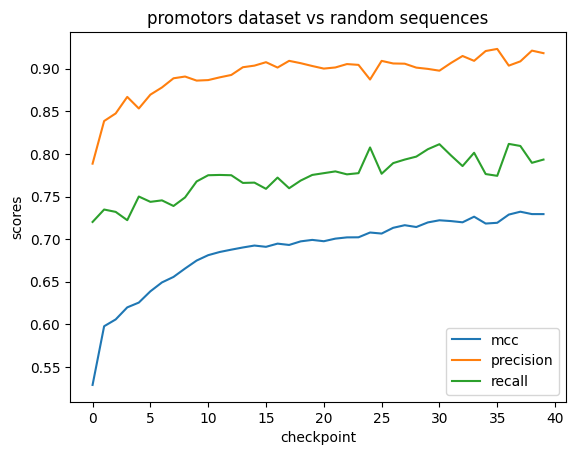

In [ ]:
plt.plot(mcc_scores, label='mcc')
plt.plot(precision_scores, label='precision')
plt.plot(recall_scores, label='recall')
plt.title('promotors dataset vs random genomic sequences')
plt.xlabel('checkpoint')
plt.ylabel('scores')
plt.legend()
plt.show()

In [ ]:
def test_new(data_path_promotors,data_path_human_random ,pretrain, ker=None):
    if ker is None:
        ker = [27, 14, 7]

    dataloader = load_data_new(data_path_promotors,data_path_human_random ,device=device)
    # Assuming `positive_dataloader` and `negative_dataloader` are already defined in the repository files
    positive_dataloader = dataloader[2]  # Your DataLoader for positive examples
    negative_dataloader = dataloader[5]  # Your DataLoader for negative examples

    # Extract datasets from each DataLoader
    positive_dataset = positive_dataloader.dataset
    negative_dataset = negative_dataloader.dataset

    # Combine the datasets
    combined_dataset = ConcatDataset([positive_dataset, negative_dataset])

    # Create a new DataLoader from the combined dataset
    combined_dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

    # model define
    net = DeePromoter(ker)
    net.to(device)

    net.load_state_dict(torch.load(pretrain,map_location=torch.device(device)))

    net.eval()
    eval_data, results, confusion_matrice = evaluate(net, [combined_dataloader])

    return eval_data, results, confusion_matrice


In [ ]:
#Load pretrained model
path_promotors_random_model = './data/models/model_random_promotors.pth'

**Excercise** Plot confusion matrix and compute accuracy for the new model. What do you think about the results?

### Summary
The results demonstrated that Deepromoter is a model with strong performance metrics. However, a deeper analysis of the problem and the data suggests that the tool isn't fulfilling its intended purpose. While Deepromoter excels at distinguishing sequence randomization, it falls short when it comes to discerning promoter regions from random genomic regions.

**Additional task** Let's examine the datasets to identify some characteristics. Plot the distribution of nucleotides in both the promoter and random sequence datasets. Can you observe any noticeable differences?